In [16]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras import models, layers
from keras.callbacks import EarlyStopping
from keras import backend
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import matplotlib.pyplot as plt
from keras.layers.embeddings import Embedding

In [8]:
df = pd.read_json('rulings.json')
dfabilities = pd.read_csv('abilities',header=None,names=['ability','rank'])

In [12]:
# Create ability score column
df['ability_score'] = 0
for dfindex,dfrows in df.iterrows():
    ability_sum = 0
    for abilindex,abilrows in dfabilities.iterrows():
        try:
            if dfrows['oracle_text'].find(abilrows['ability']) > -1:
                ability_sum += abilrows['rank']
        except:
            continue
    df.at[dfindex,'ability_score'] = ability_sum

In [9]:
# Create an ability index
ability_index = {}
count = 0
for index,rows in df.iterrows():
    try:
        words = rows['oracle_text'].lower().replace(rows['name'].lower(),'this object').split()
        for a in words:
            a = ''.join(b for b in a if b not in ['.','(',')'])
            if a not in ability_index:
                count += 1
                ability_index[a] = count
            else:
                continue
    except:
        continue

In [19]:
# Create train/test data
train_data = []
train_labels = []
test_data = []
test_labels = []
df = df.fillna(0)
for index,rows in df.iterrows():
    try:
        words = rows['oracle_text'].lower().replace(rows['name'].lower(),'this object').split()
        indices = []
        for a in words:
            a = ''.join(b for b in a if b not in ['.','(',')'])
            indices.append(ability_index[a])
        # Split train/test into 80/20
        if len(train_data) <= len(df)*.8:
            train_data.append(indices)
            train_labels.append(rows['ability_score'])
            """
            try:
                float(rows['prices']['usd'])
                train_labels.append(rows['prices']['usd'])
            except:
                train_labels.append(0)
            """
        else:
            test_data.append(indices)
            test_labels.append(rows['ability_score'])
            """
            try:
                float(rows['prices']['usd'])
                test_labels.append(rows['prices']['usd'])
            except:
                test_labels.append(0)
            """
    except:
        continue

In [24]:
# Convert data to NumPy arrays
np_train_data = np.array(train_data)
np_train_labels = np.array(train_labels)
np_test_data = np.array(test_data)
np_test_labels = np.array(test_labels)

# Convert labels to floats
np_train_labels = np_train_labels.astype(np.float)
np_test_labels = np_test_labels.astype(np.float)

In [25]:
# Normalize the labels between 0 and 1
np_train_labels = np_train_labels/np_train_labels.max()
np_test_labels = np_test_labels/np_test_labels.max()

# Set each label to 0 or 1
count = 0
for a in np_train_labels:
    # Adjust this value higher/lower to be more/less strict on what is considered good/bad
    if a < .5:
        np_train_labels[count] = 0
    else:
        np_train_labels[count] = 1
    count += 1
count = 0
for a in np_test_labels:
    # Adjust this value higher/lower to be more/less strict on what is considered good/bad
    if a < .5:
        np_test_labels[count] = 0
    else:
        np_test_labels[count] = 1
    count += 1

In [26]:
# This function will create a tensor that is 17537 by 5402. 17537 is the number of samples
# and 5402 is the number of unique words. The tensor will have all zeros except for ones where that word is in the ability
def vectorize_sequences(sequences, dimension=5402):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [27]:
# Apply the vectorize function to the train_data and test_data
x_train = vectorize_sequences(np_train_data)
x_test = vectorize_sequences(np_test_data)

In [28]:
# View the train shape, values, and dimensions
print(x_train.shape)
print(x_train[0])
print(x_train.ndim)

(17537, 5402)
[0. 1. 1. ... 0. 0. 0.]
2


In [29]:
y_train = np.asarray(np_train_labels).astype('float32')
y_test = np.asarray(np_test_labels).astype('float32')

In [30]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

Train on 13152 samples, validate on 4385 samples
Epoch 1/20
13152/13152 [==============================] - 1s 110us/step - loss: 1.6304 - acc: 0.5528 - val_loss: 0.9497 - val_acc: 0.7802
Epoch 2/20
13152/13152 [==============================] - 1s 53us/step - loss: 0.9269 - acc: 0.7015 - val_loss: 0.7512 - val_acc: 0.9770
Epoch 3/20
13152/13152 [==============================] - 1s 53us/step - loss: 0.7340 - acc: 0.9319 - val_loss: 0.6449 - val_acc: 0.9966
Epoch 4/20
13152/13152 [==============================] - 1s 53us/step - loss: 0.6108 - acc: 0.9845 - val_loss: 0.5452 - val_acc: 0.9966
Epoch 5/20
13152/13152 [==============================] - 1s 53us/step - loss: 0.5076 - acc: 0.9948 - val_loss: 0.4768 - val_acc: 0.9966
Epoch 6/20
13152/13152 [==============================] - 1s 53us/step - loss: 0.4262 - acc: 0.9958 - val_loss: 0.4009 - val_acc: 0.9966


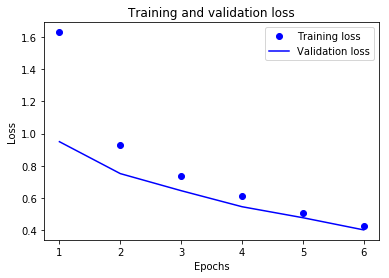

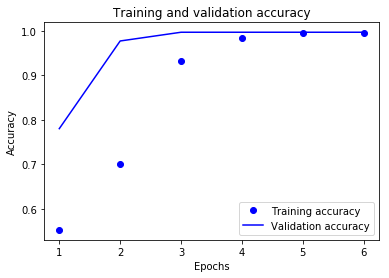

4015/4015 [==============================] - 0s 71us/step
['loss', 'acc']
[0.6462870415982096, 0.9952677459526774]


In [35]:
np.random.seed(42)
backend.clear_session()
model = models.Sequential()
model.add(layers.Dense(16, activation = 'relu', kernel_regularizer = regularizers.l1_l2(l1 = 0.001, l2 = 0.001), input_shape = (5402,)))
model.add(layers.Dropout(0.2))
model.add(BatchNormalization())
model.add(layers.Dense(16, kernel_regularizer = regularizers.l1_l2(l1 = 0.001, l2 = 0.001), activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(BatchNormalization())
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

history = model.fit(x_train,
                   y_train,
                   epochs = 20,
                   batch_size = 500,
                   validation_data = (x_val, y_val),
                   callbacks=[EarlyStopping(monitor='val_acc', patience=3, restore_best_weights = True)])

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

results = model.evaluate(x_test, y_test)
print(model.metrics_names)
print(results)

### Another method found here
##### https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [5]:
docs = df['oracle_text'].copy()

In [6]:
docs[0]

"As long as Static Orb is untapped, players can't untap more than two permanents during their untap steps."

In [7]:
# Convert all non-str values into empty strings
count = 0
for a in docs:
    try:
        a.lower()
    except:
        docs[count] = ''
    finally:
        count += 1

In [14]:
# Define labels
labels = df['ability_score'].copy()

# Normalize the labels between 0 and 1
labels = labels/labels.max()

# Set each label to 0 or 1
count = 0
for a in labels:
    # Adjust this value higher/lower to be more/less strict on what is considered good/bad
    if a < .5:
        labels[count] = 0
    else:
        labels[count] = 1
    count += 1

In [15]:
# Vocab size should be greater than number of unique words to prevent collisions
vocab_size = 5000
encoded_docs = [one_hot(d, vocab_size) for d in docs]
# Max Length is maximum number of words allowed in an ability
max_length = 20
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# define the model
model = Sequential()
# 16 is the dimensions (features/attributes) for a specific document
model.add(Embedding(vocab_size, 16, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

W0927 10:59:57.046233 16296 deprecation_wrapper.py:119] From C:\Users\Taylor\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0927 10:59:57.058168 16296 deprecation_wrapper.py:119] From C:\Users\Taylor\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0927 10:59:57.060194 16296 deprecation_wrapper.py:119] From C:\Users\Taylor\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0927 10:59:57.082134 16296 deprecation_wrapper.py:119] From C:\Users\Taylor\Anaconda3\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0927 10:59:57.098091 16296 deprecation_wrapper.py:119] From C:\Users\Taylor

Accuracy: 99.981753
